In [1]:
import time

import awkward as ak
import hist
import matplotlib.pyplot as plt
import numpy as np
from coffea.nanoevents import NanoEventsFactory
from coffea import processor

import dask
import dask_awkward as dak
import hist.dask as hda

from distributed import Client
client=Client()

# The opendata files are non-standard NanoAOD, so some optional data columns are missing
processor.NanoAODSchema.warn_missing_crossrefs = False

events = NanoEventsFactory.from_root(
    "file:/Users/lgray/coffea-dev/coffea/Run2012B_SingleMu.root",
    treepath="Events",
    chunks_per_file=500,
    permit_dask=True,
    metadata={"dataset": "SingleMu"}
).events()

2023-04-19 12:14:32,175 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/_8/wdyynsx91n91t7x7xwn69bsc0000gn/T/dask-worker-space/worker-j0ugdof4', purging
2023-04-19 12:14:32,176 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/_8/wdyynsx91n91t7x7xwn69bsc0000gn/T/dask-worker-space/worker-cjl0v_xp', purging
2023-04-19 12:14:32,176 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/_8/wdyynsx91n91t7x7xwn69bsc0000gn/T/dask-worker-space/worker-93b3rnf_', purging
2023-04-19 12:14:32,176 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/_8/wdyynsx91n91t7x7xwn69bsc0000gn/T/dask-worker-space/worker-6k2ued72', purging
2023-04-19 12:14:32,176 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/_8/wdyynsx91n91t7x7xwn69bsc0000gn/T/dask-worker-space/worker-507hain9', purging


# Query 1

Plot the <i>E</i><sub>T</sub><sup>miss</sup> of all events.

{'from-uproot-f263c72ae8ec0603747763b034e6e982': ['MET.pt']}

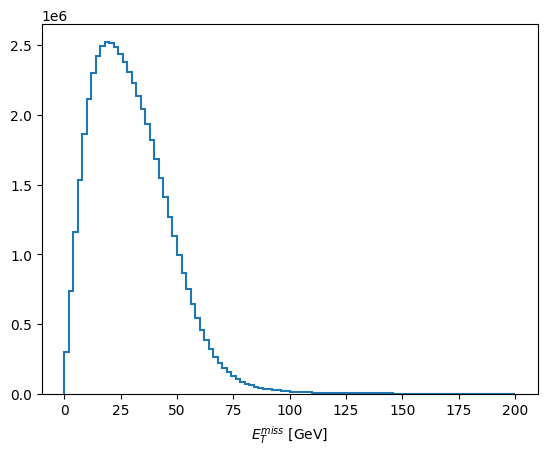

In [2]:
q1_hist = (
    hda.Hist.new.Reg(100, 0, 200, name="met", label="$E_{T}^{miss}$ [GeV]")
    .Double()
    .fill(events.MET.pt)
)

q1_hist.compute().plot1d()
dak.necessary_columns(q1_hist)

# Query 2
Plot the <i>p</i><sub>T</sub> of all jets.

{'from-uproot-f263c72ae8ec0603747763b034e6e982': ['Jet.pt']}

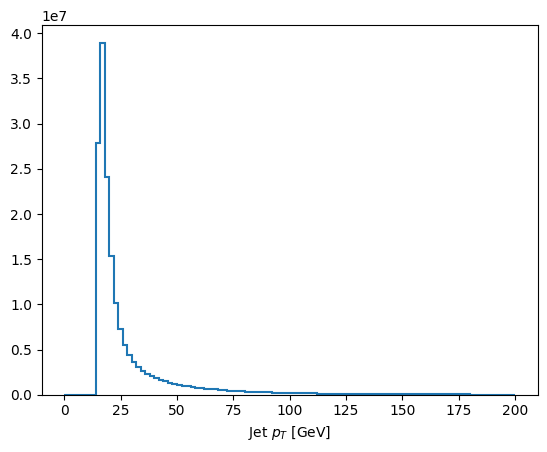

In [3]:
q2_hist = (
    hda.Hist.new.Reg(100, 0, 200, name="ptj", label="Jet $p_{T}$ [GeV]")
    .Double()
    .fill(dak.flatten(events.Jet.pt))
)


q2_hist.compute().plot1d()
dak.necessary_columns(q2_hist)

# Query 3
Plot the <i>p</i><sub>T</sub> of jets with |<i>η</i>| < 1.

{'from-uproot-f263c72ae8ec0603747763b034e6e982': ['Jet.pt', 'Jet.eta']}

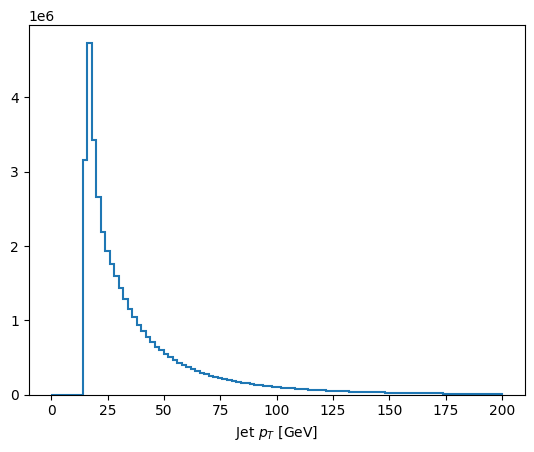

In [4]:
q3_hist = (
    hda.Hist.new.Reg(100, 0, 200, name="ptj", label="Jet $p_{T}$ [GeV]")
    .Double()
    .fill(dak.flatten(events.Jet[abs(events.Jet.eta) < 1].pt))
)

q3_hist.compute().plot1d()
dak.necessary_columns(q3_hist)

# Query 4
Plot the <i>E</i><sub>T</sub><sup>miss</sup> of events that have at least two jets with <i>p</i><sub>T</sub> > 40 GeV.

{'from-uproot-f263c72ae8ec0603747763b034e6e982': ['MET.pt', 'Jet.pt']}

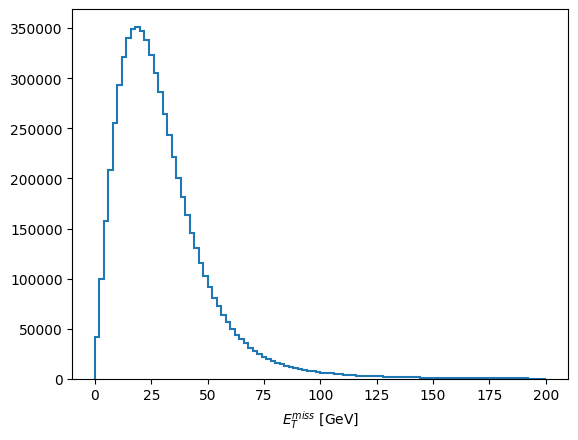

In [5]:
has2jets = dak.sum(events.Jet.pt > 40, axis=1) >= 2
q4_hist = (
    hda.Hist.new.Reg(100, 0, 200, name="met", label="$E_{T}^{miss}$ [GeV]")
    .Double()
    .fill(events[has2jets].MET.pt)
)

q4_hist.compute().plot1d()
dak.necessary_columns(q4_hist)

# Query 5
Plot the <i>E</i><sub>T</sub><sup>miss</sup> of events that have an
opposite-charge muon pair with an invariant mass between 60 and 120 GeV.

/Users/lgray/miniforge3/envs/coffea-dev/lib/python3.8/site-packages/awkward/_backends/backend.py:47: RuntimeWarning: invalid value encountered in sqrt
  return getattr(ufunc, method)(*args, **kwargs)
2023-04-19 12:15:22,936 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
/Users/lgray/miniforge3/envs/coffea-dev/lib/python3.8/site-packages/awkward/_backends/backend.py:47: RuntimeWarning: invalid value encountered in sqrt
  return getattr(ufunc, method)(*args, **kwargs)
2023-04-19 12:15:23,326 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-19 12:15:24,580 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-19 12:15:24,792 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
/Users/lgray/miniforge3/envs/coffea-dev/lib/python3.8/site-packages/awkward/_bac

{'from-uproot-f263c72ae8ec0603747763b034e6e982': ['Muon.phi',
  'Muon.mass',
  'Muon.charge',
  'MET.pt',
  'Muon.eta',
  'Muon.pt']}

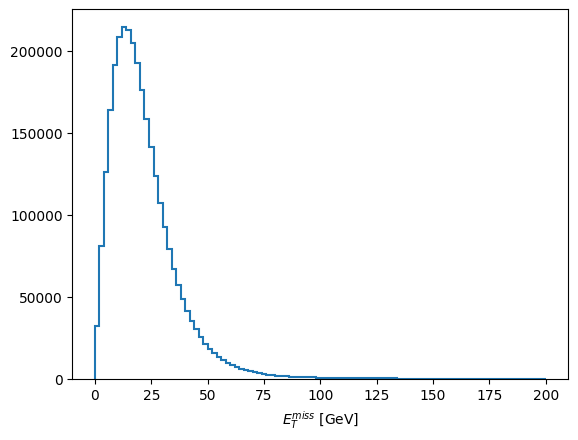

In [6]:
mupair = dak.combinations(events.Muon, 2, fields=["mu1", "mu2"])
pairmass = (mupair.mu1 + mupair.mu2).mass
goodevent = dak.any(
    (pairmass > 60)
    & (pairmass < 120)
    & (mupair.mu1.charge == -mupair.mu2.charge),
    axis=1,
)
q5_hist = (
    hda.Hist.new.Reg(100, 0, 200, name="met", label="$E_{T}^{miss}$ [GeV]")
    .Double()
    .fill(events[goodevent].MET.pt)
)


q5_hist.compute().plot1d()
dak.necessary_columns(q5_hist)

# Query 6
For events with at least three jets, plot the <i>p</i><sub>T</sub> of the trijet four-momentum that has the invariant mass closest to 172.5 GeV in each event and plot the maximum <i>b</i>-tagging discriminant value among the jets in this trijet.

/Users/lgray/miniforge3/envs/coffea-dev/lib/python3.8/site-packages/awkward/_backends/backend.py:47: RuntimeWarning: invalid value encountered in sqrt
  return getattr(ufunc, method)(*args, **kwargs)
2023-04-19 12:16:01,508 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-04-19 12:16:02,840 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-04-19 12:16:04,082 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-04-19 12:16:04,340 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
/Users/lgray/miniforge3/envs/coffea-dev/lib/python3.8/site-packages/awkward/_backends/backend.py:47: RuntimeWarning: invalid value encountered in sqrt
  return getattr(ufunc, method)(*args, **kwargs)
2023-04-19 12:16:05,299 - distributed.utils_perf - WARNING - full garbage collec

{'from-uproot-f263c72ae8ec0603747763b034e6e982': ['Jet.eta',
  'Jet.pt',
  'Jet.phi',
  'Jet.mass',
  'Jet.btag']}

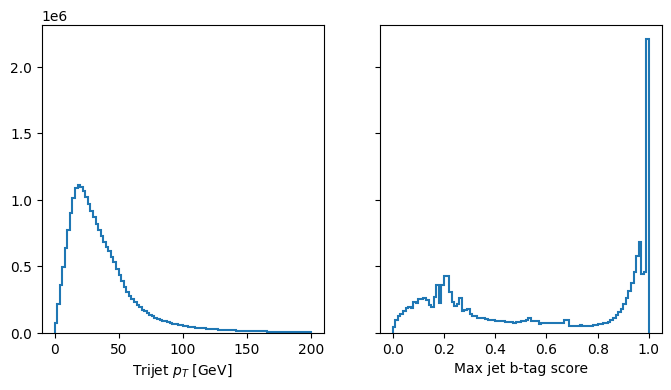

In [7]:
jets = dak.zip(
    {k: getattr(events.Jet, k) for k in ["x", "y", "z", "t", "btag"]},
    with_name="LorentzVector",
    behavior=events.Jet.behavior,
)
trijet = dak.combinations(jets, 3, fields=["j1", "j2", "j3"])
trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3
trijet = dak.flatten(
    trijet[dak.singletons(dak.argmin(abs(trijet.p4.mass - 172.5), axis=1))]
)
maxBtag = np.maximum(
    trijet.j1.btag,
    np.maximum(
        trijet.j2.btag,
        trijet.j3.btag,
    ),
)
q6_hists = {
    "trijetpt": hda.Hist.new.Reg(
        100, 0, 200, name="pt3j", label="Trijet $p_{T}$ [GeV]"
    )
    .Double()
    .fill(trijet.p4.pt),
    "maxbtag": hda.Hist.new.Reg(
        100, 0, 1, name="btag", label="Max jet b-tag score"
    )
    .Double()
    .fill(maxBtag),
}

out = dask.compute(q6_hists)[0]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
out["trijetpt"].plot1d(ax=ax1)
out["maxbtag"].plot1d(ax=ax2)
dak.necessary_columns(q6_hists)

# Query 7
Plot the scalar sum in each event of the <i>p</i><sub>T</sub> of jets with <i>p</i><sub>T</sub> > 30 GeV that are not within 0.4 in Δ<i>R</i> of any light lepton with <i>p</i><sub>T</sub> > 10 GeV.

{'from-uproot-f263c72ae8ec0603747763b034e6e982': ['Jet.eta',
  'Electron.phi',
  'Muon.phi',
  'Jet.pt',
  'Electron.pt',
  'Jet.phi',
  'Muon.eta',
  'Electron.eta',
  'Muon.pt']}

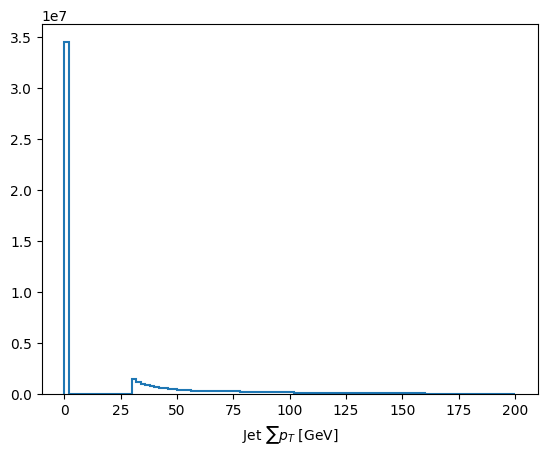

In [8]:
cleanjets = events.Jet[
    dak.all(
        events.Jet.metric_table(events.Muon[events.Muon.pt > 10]) >= 0.4, axis=2
    )
    & dak.all(
        events.Jet.metric_table(events.Electron[events.Electron.pt > 10]) >= 0.4,
        axis=2,
    )
    & (events.Jet.pt > 30)
]
q7_hist = (
    hda.Hist.new.Reg(
        100, 0, 200, name="sumjetpt", label="Jet $\sum p_{T}$ [GeV]"
    )
    .Double()
    .fill(dak.sum(cleanjets.pt, axis=1))
)

q7_hist.compute().plot1d()
dak.necessary_columns(q7_hist)

# Query 8
For events with at least three light leptons and a same-flavor opposite-charge light lepton pair, find such a pair that has the invariant mass closest to 91.2 GeV in each event and plot the transverse mass of the system consisting of the missing tranverse momentum and the highest-<i>p</i><sub>T</sub> light lepton not in this pair.

In [10]:
events["Electron", "pdgId"] = -11 * events.Electron.charge
events["Muon", "pdgId"] = -13 * events.Muon.charge
events["leptons"] = dak.concatenate(
    [events.Electron, events.Muon],
    axis=1,
)
events = events[dak.num(events.leptons) >= 3]
pair = dak.argcombinations(events.leptons, 2, fields=["l1", "l2"])
pair = pair[(events.leptons[pair.l1].pdgId == -events.leptons[pair.l2].pdgId)]
x = events.leptons[pair.l1] + events.leptons[pair.l2]

pair = pair[
    dak.singletons(
        dak.argmin(
            abs(
                (events.leptons[pair.l1] + events.leptons[pair.l2]).mass
                - 91.2
            ),
            axis=1,
        )
    )
]
events = events[dak.num(pair) > 0]
pair = pair[dak.num(pair) > 0][:, 0]

l3 = dak.local_index(events.leptons)
l3 = l3[(l3 != pair.l1) & (l3 != pair.l2)]
l3 = l3[dak.argmax(events.leptons[l3].pt, axis=1, keepdims=True)]
l3 = events.leptons[l3][:, 0]

mt = np.sqrt(2 * l3.pt * events.MET.pt * (1 - np.cos(events.MET.delta_phi(l3))))
q8_hist = (
    hist.Hist.new.Reg(
        100, 0, 200, name="mt", label="$\ell$-MET transverse mass [GeV]"
    )
    .Double()
    .fill(mt)
)

out, metrics = run(Q8Processor)
q8_hist.compute().plot1d()
dak.necessary_columns(q8_hist)

AssertionError: 

See if this has been reported at https://github.com/scikit-hep/awkward/issues